In [1]:
import jax
jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
jax.config.update("jax_platforms", "cpu")
import jax.numpy as jnp

import numpy as np
import equinox as eqx
import matplotlib.pyplot as plt
from skimage.morphology import footprint_rectangle

In [2]:
from xpektra import SpectralSpace, make_field
from xpektra.transform import FFTTransform
from xpektra.spectral_operator import SpectralOperator
from xpektra.scheme import FourierScheme, RotatedDifference
from xpektra.projection_operator import GalerkinProjection


from xpektra.solvers.nonlinear import newton_krylov_solver, conjugate_gradient_while

In [3]:
N = 99
ndim = 2
length = 10
dx = length / N
ell = 0.2

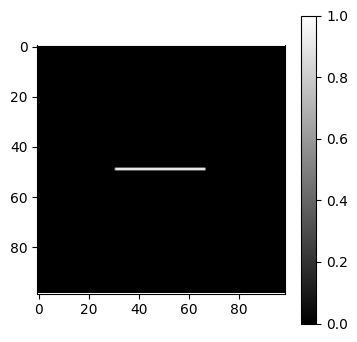

In [4]:
def create_structure(N):
    Hmid = int(N / 2)
    Lmid = int(N / 2)
    r = int(N / 10)

    structure = np.zeros((N, N))
    structure[Hmid : Hmid + 1, Lmid - 2 * r : Lmid + 2 * r] += footprint_rectangle(
        (1, 4 * r)
    )

    return structure


structure = create_structure(N)
plt.figure(figsize=(4, 4))
cb = plt.imshow(structure, cmap="gray")
plt.colorbar(cb)
plt.show()

Spatial and FFT operators that we need for solving of frature problem. 

In [19]:
fft_transform = FFTTransform(ndim)
space = SpectralSpace(shape=(N, N), lengths=(length, length), transform=fft_transform)
diff_scheme = RotatedDifference(space=space)
op = SpectralOperator(scheme=diff_scheme, space=space)

The total energy of the material undergoing fracture can be given as 

\begin{align}
\psi(\varepsilon_{ij}) &= \psi_{elastic} + \psi_{fracture} \\
\psi &= g(\alpha)\psi_{e}^{+} + \psi_{e}^{-} + \dfrac{G_{c}}{c_w}(\dfrac{w(\alpha)}{l} + l|\nabla\alpha|^{2})
\end{align}


Defining the elastic strain energy with degradation of only `positive` energy part, we use the `volumetric-deviatoric` split to define the positive and negative part.




### Elasticity subproblem

Now, we divided the problem into two subproblems: elastic and fracture. taking the first variation of functional $\psi$ with respect to $\varepsilon$ and $\alpha$. The first  variation of functional $F[u]$ is defined as :

\begin{align}
\delta F[u] &= \lim_{\epsilon\to 0} \dfrac{F[u+\epsilon\delta u] - F[u]}{\epsilon} = \lim_{\epsilon\to0} \dfrac{\text{d}}{\text{d}\epsilon} I[u+\epsilon\delta u]
\end{align}
The above is also called Gateaux derivative. 

For functional form that may involve $u$ as well as  its partial derivatives, we can define the first variation as follows:

\begin{align}
I[u] &= \int f(u, \nabla u, ...) dV \to \delta I[u] = \int \big( \dfrac{\partial f}{\partial u_i}\delta u_{i} + \dfrac{\partial f}{\partial u_{i,j}}\delta u_{i, j} + ....\big) dV 
\end{align}

The first variation of $\psi$ with respect to $\varepsilon$

\begin{align}
\delta \psi(\varepsilon) &= \int \dfrac{\partial \psi}{\partial \varepsilon}\delta\varepsilon dV \\
&= \int \underbrace{\Big(g(\alpha) \dfrac{\partial \psi_e^{+}}{\partial \varepsilon} + \dfrac{\partial \psi_{e}^{-}}{\partial \varepsilon}\Big)}_{\sigma}\delta \varepsilon dV
\end{align} 

For this subproblem,we solve the weak form given as 

$$\delta \psi(\epsilon) = \int \sigma \delta \epsilon dV = 0$$

and we use  the Fourier-Galerkin method for that. 

For FFT scheme, we define the above strain expression for each grid point ($x,y$)

$$\psi_{xy} = \dfrac{1}{2}(\text{tr}(\varepsilon_{iixy})^2 + \mu \text{tr}(\varepsilon_{ijxy}\varepsilon_{jkxy} ) $$
$$\sigma_{ijxy} = \dfrac{\partial \psi_{xy}}{\partial \varepsilon_{ijxy}}$$




In [20]:
E_solid = 1.
E_void = 1e-3
nu = 0.3

Gc = 1e-2
lambda_solid = E_solid * nu / ((1 + nu) * (1 - 2 * nu))
lambda_void = E_void * nu / ((1 + nu) * (1 - 2 * nu))
mu_solid = E_solid / (2 * (1 + nu))
mu_void = E_void / (2 * (1 + nu))

lambda_field = lambda_solid * (1-structure) + lambda_void * structure
mu_field = mu_solid * (1-structure) + mu_void * structure
bulk_field = lambda_field + 2 * mu_field / 3


elasticity_dofs_shape = make_field(dim=ndim, shape=(N, N), rank=2).shape
fracture_dofs_shape = make_field(dim=ndim, shape=(N, N), rank=0).shape

In [21]:
i = jnp.eye(ndim)
I = make_field(dim=ndim, shape=(N, N), rank=2) + i

cw = 2 / 3.0
kappa = 1e-1


@jax.jit
def g(alpha):
    return (1 - alpha) ** 2 + kappa


@jax.jit
def w(alpha):
    return alpha  # 0.5*alpha**2 # alpha


@jax.jit
def no_split(eps):
    eps_sym = 0.5 * (eps + op.trans(eps))
    energy = 0.5 * jnp.multiply(lambda_field, op.trace(eps_sym) ** 2) + jnp.multiply(
        mu_field, op.trace(op.dot(eps_sym, eps_sym))
    )
    return energy


@jax.jit
def vol_dev_split(eps):
    def macluay_plus(A):
        return 0.5 * (A + jnp.abs(A))

    def macluay_minus(A):
        return 0.5 * (A - jnp.abs(A))

    esp_plus = macluay_plus(op.trace(eps))
    esp_minus = macluay_minus(op.trace(eps))
    eps_dev = (
        eps - jnp.einsum("ij, ...->...ij", jnp.eye(ndim), op.trace(eps)) / 3
    )  # deviatoric strain

    strain_energy_plus = 0.5 * jnp.multiply(
        bulk_field, jnp.multiply(esp_plus, esp_plus)
    ) + jnp.multiply(mu_field, op.ddot(eps_dev, eps_dev))
    strain_energy_minus = 0.5 * jnp.multiply(
        mu_field, jnp.multiply(esp_minus, esp_minus)
    )

    return strain_energy_plus, strain_energy_minus


@jax.jit
def spectral_split(eps):
    def macluay_plus(A):
        return 0.5 * (A + jnp.abs(A))

    def macluay_minus(A):
        return 0.5 * (A - jnp.abs(A))

    eps_eg = jnp.linalg.eig(eps)


@jax.jit
def strain_energy(eps_flat, alpha_flat):
    eps = eps_flat.reshape(elasticity_dofs_shape)
    alpha = alpha_flat.reshape(fracture_dofs_shape)
    eps_sym = 0.5 * (eps + op.trans(eps))
    strain_energy_plus, strain_energy_minus = vol_dev_split(eps_sym)
    energy = g(alpha) * strain_energy_plus + strain_energy_minus
    # strain_energy = no_split(eps_sym)
    # energy = g(alpha)*strain_energy
    return energy.sum()


compute_stress = jax.jacrev(strain_energy)

In [22]:
Ghat = GalerkinProjection(scheme=diff_scheme)

In [23]:
from jax import Array

class ElasticityResidual(eqx.Module):
    """A callable module that computes the residual vector."""

    dofs_shape: tuple = eqx.field(static=True)
 
    # We can even pre-define the stress function if it's always the same
    # For this example, we'll keep your original `compute_stress` function
    # available in the global scope.

    @eqx.filter_jit
    def __call__(self, eps_flat: Array, alpha_flat: Array) -> Array:
        """
        This makes instances of this class behave like a function.
        It takes only the flattened vector of unknowns, as required by the solver.
        """
        eps_flat = eps_flat.reshape(-1)
        alpha_flat = alpha_flat.reshape(-1)
        sigma = compute_stress(eps_flat, alpha_flat)
        residual_field = op.inverse(
            Ghat.project(op.forward(sigma.reshape(self.dofs_shape)))
        )
        return jnp.real(residual_field).reshape(-1)


class ElasticityJacobian(eqx.Module):
    """A callable module that represents the Jacobian operator (tangent)."""

    dofs_shape: tuple = eqx.field(static=True)

    @eqx.filter_jit
    def __call__(self, deps_flat: Array, alpha_flat: Array) -> Array:
        """
        The Jacobian is a linear operator, so its __call__ method
        represents the Jacobian-vector product.
        """

        deps_flat = deps_flat.reshape(-1)
        alpha_flat = alpha_flat.reshape(-1)
        dsigma = compute_stress(deps_flat, alpha_flat)
        jvp_field = op.inverse(
            Ghat.project(op.forward(dsigma.reshape(self.dofs_shape)))
        )
        return jnp.real(jvp_field).reshape(-1)

In [24]:
alpha0    = structure 

applied_strains = jnp.diff(jnp.linspace(0, 1e-2, num=2))

deps = make_field(dim=ndim, shape=structure.shape, rank=2)
eps = make_field(dim=ndim, shape=structure.shape, rank=2)

residual_fn = ElasticityResidual(dofs_shape=eps.shape)
jacobian_fn = ElasticityJacobian(dofs_shape=eps.shape)


for inc, deps_avg in enumerate(applied_strains):
 
    # solving for elasticity
    deps[:, :, 0, 0] = deps_avg

    b = -jacobian_fn(deps.reshape(-1), alpha_flat=alpha0.reshape(-1))
    eps = eps + deps


    residual_partial = eqx.Partial(residual_fn, alpha_flat=alpha0.reshape(-1))
    jacobian_partial = eqx.Partial(jacobian_fn, alpha_flat=alpha0.reshape(-1))

    final_state = newton_krylov_solver(
        state=(deps, b, eps),
        gradient=residual_partial,
        jacobian=jacobian_partial,
        tol=1e-8,
        max_iter=20,
        krylov_solver=conjugate_gradient_while,
        krylov_tol=1e-8,
        krylov_max_iter=50,
    )
    eps = final_state[2]

eps = final_state[2].reshape(elasticity_dofs_shape)
sig = compute_stress(final_state[2], alpha_flat=alpha0.reshape(-1)).reshape(elasticity_dofs_shape)


CG error = 0.00665597874812
CG error = 0.04208997362185
CG error = 0.00755436446728
CG error = 0.00152267566439
CG error = 0.00035242301705
CG error = 0.00007793399998
CG error = 0.00001749198003
CG error = 0.00000384712442
CG error = 0.00000097593274
CG error = 0.00000022532422
CG error = 0.00000005527756
CG error = 0.00000001272804
CG error = 0.00000000307113
CG error = 0.00000000070882
CG error = 0.00000000017158
CG error = 0.00000000004001
CG error = 0.00000000000971
CG error = 0.00000000000226
CG error = 0.00000000000055
CG error = 0.00000000000013
Didnot converge, Residual value : 1.7624023255350627e-07


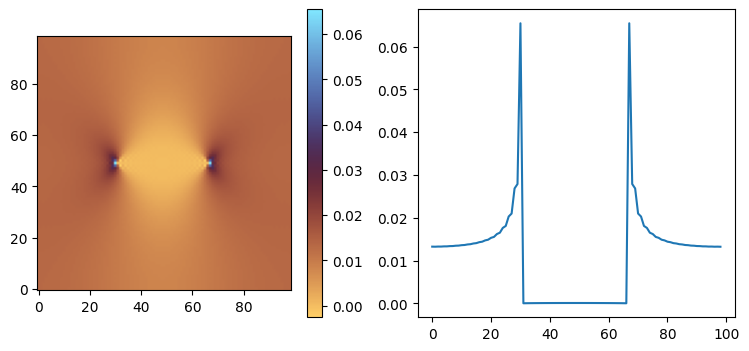

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
cb = ax1.imshow(sig.at[:, :, 0, 0].get(), cmap="managua", origin='lower')
fig.colorbar(cb, ax=ax1)

ax2.plot(sig.at[:, :, 0, 0].get()[N//2, :])
plt.show()

In [26]:
op.grad(alpha0).shape

(99, 99, 2)

## phasefield subproblem

The first variation of $\psi$ with respect to $\alpha$ 

\begin{align}
\delta \psi(\alpha) &= \int \big( \dfrac{\partial \psi}{\partial \alpha}\delta \alpha + \dfrac{\partial \psi}{\partial \nabla \alpha}\delta \nabla \alpha \big) dV \\
&= \int \Big ( \psi_{e}^{+}\dfrac{\partial g(\alpha)}{\partial \alpha}\delta \alpha + \dfrac{G_{c}}{c_w}\dfrac{1}{l}\dfrac{\partial w(\alpha)}{\partial \alpha}\delta \alpha + 2\dfrac{G_{c}}{c_w}\nabla\alpha \delta\nabla \alpha\Big) dV
\end{align}

We can apply intergation by parts to the last term

$$ \int \nabla \alpha \delta \nabla \alpha dV =  \nabla \alpha \delta \alpha |_{\Gamma} - \int \nabla ( \nabla \alpha ) \delta \alpha~ dV  $$

and since $\delta \alpha=0$ at the boundaries we can say that the first variation of $\psi$ w.r.t $\alpha$

$$ \delta \psi(\alpha) =  \int \Big ( \psi_{e}^{+}\dfrac{\partial g(\alpha)}{\partial \alpha} + \dfrac{G_{c}}{c_w}\dfrac{1}{l}\dfrac{\partial w(\alpha)}{\partial \alpha} - 2\ell\dfrac{G_{c}}{c_w}\nabla \cdot{} \nabla \alpha  \Big) \delta \alpha dV = 0$$

For this subproblem we chose to solve the strong form rather than the above weak form. The strong form is given from the above weak form. Since the above equation holds for any $\delta \alpha$ therefore, we can say 

$$ \psi_{e}^{+}\dfrac{\partial g(\alpha)}{\partial \alpha} + \dfrac{G_{c}}{c_w}\dfrac{1}{l}\dfrac{\partial w(\alpha)}{\partial \alpha} - 2\ell \dfrac{G_{c}}{c_w}\nabla \cdot{} \nabla \alpha = 0 $$



We use `AT1` phasefield formulation for the phasefield degradation function. 

In [27]:
@jax.jit
def g_sum(alpha):
    return g(alpha).sum()


@jax.jit
def w_sum(alpha):
    return w(alpha).sum()


dgdalpha = jax.jit(jax.grad(g_sum))
dwdalpha = jax.jit(jax.grad(w_sum))


@jax.jit
def fracture_strong_form(alpha, epsilon):
    alpha = alpha.reshape((N, N))

    eps_sym = 0.5 * (epsilon + op.trans(epsilon))
    strain_energy_plus, _ = vol_dev_split(eps_sym)

    res = (
        jnp.multiply(strain_energy_plus, dgdalpha(alpha))
        + jnp.multiply(Gc, dwdalpha(alpha)) / ell / cw
        - 2 * ell * jnp.multiply(Gc, op.laplacian(alpha)) / cw
    )
    return res.reshape(-1)

The phasefield subproblem is a root-finding problem under cosntraints and is given as 

Find $\alpha $ for a given $\varepsilon$ such that
$$ \psi_{e}^{+}\dfrac{\partial g(\alpha)}{\partial \alpha} + \dfrac{G_{c}}{c_w}\dfrac{1}{l}\dfrac{\partial w(\alpha)}{\partial \alpha} - 2\ell\dfrac{G_{c}}{c_w}\nabla \cdot{} \nabla \alpha = 0 $$

and the constraint is $\alpha_\textsf{prev} < \alpha < 1 $ for irreversibility.


In [ ]:
import jax.scipy.sparse.linalg as jsl


def projected_gauss_newton(
    F,                  # function F(alpha) -> residual vector (jax array)
    alpha0,             # initial guess (full-sized vector)
    lb,                 # lower bound (full-sized vector)
    ub,                 # upper bound (full-sized vector)
    max_iter=200,
    tol=1e-10,
    solver_tol=1e-8,    # Tolerance for the CG solver
    solver_maxiter=None # Max iterations for the CG solver
):
    """
    Solve F(alpha) = 0 subject to lb <= alpha <= ub using a
    projected Gauss-Newton method (matching PETSc's KSP 'cg').
    
    This solves the normal equations (J^T J) * delta = -J^T F
    in the projected free space.
    """

    if solver_maxiter is None:
        solver_maxiter = alpha0.size

    # Jacobian-vector product: Jv(v) = J(alpha) @ v
    def Jv_full(v, alpha):
        return jax.jvp(F, (alpha,), (v,))[1]

    # Vector-Jacobian product (transpose): vJ(v) = v^T @ J(alpha)
    def vJ_full(v, alpha):
        # jax.vjp returns (primals_out, vjp_fun)
        _, vjp_fun = jax.vjp(F, alpha)
        # vjp_fun(v) returns a tuple of gradients; we want the one for alpha
        return vjp_fun(v)[0]

    alpha = alpha0

    for it in range(max_iter):
        res = F(alpha)
        fnorm = jnp.linalg.norm(res)

        print(f"Iter {it}, ||F||={fnorm}")

        if fnorm < tol:
            return alpha

        # Identify active set
        eps_proj = 1e-12
        at_lb = (alpha <= lb + eps_proj)
        at_ub = (alpha >= ub - eps_proj)
        active = at_lb | at_ub

        n_free = alpha.size - int(jnp.sum(active))
        if n_free == 0:
            print("All variables are active; no further progress can be made.")
            return alpha

        # --- Define the full-space projected Gauss-Newton operator ---
        # This operator A(v) computes (P_F @ J^T @ J @ P_F) @ v
        def projected_JTJ_v(v):
            # 1. Project input: v_in = P_F @ v
            v_in = jnp.where(active, 0.0, v)
            
            # 2. Apply J: Jv = J @ v_in
            Jv = Jv_full(v_in, alpha)
            
            # 3. Apply J^T: JTJv = J^T @ Jv
            # We don't need to project Jv because J^T will only
            # produce output in the free-space anyway (conceptually).
            JTJv = vJ_full(Jv, alpha)

            # 4. Project output: v_out = P_F @ JTJv
            v_out = jnp.where(active, 0.0, JTJv)
            
            return v_out

        # --- Define the full-space projected right-hand side ---
        # This is b = -P_F @ (J^T F)
        JT_F = vJ_full(res, alpha)
        r_full = jnp.where(active, 0.0, -JT_F)

        # --- Solve the (symmetric) projected system using CG ---
        delta, exit_code = jsl.cg(
            projected_JTJ_v, 
            r_full, 
            tol=solver_tol, 
            maxiter=solver_maxiter
        )
        
        if exit_code != 0:
            print(f"Warning: CG solver did not converge. Exit code: {exit_code}")

        # --- TODO: ADD A LINE SEARCH HERE ---

        step = 1.0
        fnorm_old_sq = fnorm**2
        for _ in range(50): # Max 10 line search steps
            alpha_new = jnp.clip(alpha + step * delta, lb, ub)
            res_new = F(alpha_new)
            fnorm_new_sq = jnp.linalg.norm(res_new)**2
    
            # Armijo condition (sufficient decrease)
            if fnorm_new_sq < fnorm_old_sq: # (simplified version)
                alpha = alpha_new
                break
    
            step /= 2.0 # Decrease step size
        else:
            # Line search failed
            print("Line search failed to find a better point.")
            return alpha
    raise RuntimeError("Projected Gauss-Newton failed to converge within max_iter")

In [38]:
def projected_levenberg_marquardt(
    F,                  # function F(alpha) -> residual vector (jax array)
    alpha0,             # initial guess (full-sized vector)
    lb,                 # lower bound (full-sized vector)
    ub,                 # upper bound (full-sized vector)
    max_iter=200,
    tol=1e-10,
    solver_tol=1e-8,    # Tolerance for the CG solver
    solver_maxiter=None,
    damping=1e-4        # Damping parameter (lambda)
):
    """
    Solve F(alpha) = 0 subject to lb <= alpha <= ub using a
    projected Levenberg-Marquardt method.
    
    This solves the damped normal equations
    (J^T J + damping*I) * delta = -J^T F
    in the projected free space.
    """

    if solver_maxiter is None:
        solver_maxiter = alpha0.size

    # Jacobian-vector product: Jv(v) = J(alpha) @ v
    def Jv_full(v, alpha):
        return jax.jvp(F, (alpha,), (v,))[1]

    # Vector-Jacobian product (transpose): vJ(v) = v^T @ J(alpha)
    def vJ_full(v, alpha):
        _, vjp_fun = jax.vjp(F, alpha)
        return vjp_fun(v)[0]

    alpha = alpha0

    for it in range(max_iter):
        res = F(alpha)
        fnorm = jnp.linalg.norm(res)

        print(f"Iter {it}, ||F||={fnorm}")

        if fnorm < tol:
            return alpha

        # Identify active set
        eps_proj = 1e-12
        at_lb = (alpha <= lb + eps_proj)
        at_ub = (alpha >= ub - eps_proj)
        active = at_lb | at_ub

        n_free = alpha.size - int(jnp.sum(active))
        if n_free == 0:
            print("All variables are active; no further progress can be made.")
            return alpha

        # --- Define the full-space projected Levenberg-Marquardt operator ---
        # This operator A(v) computes (P_F @ J^T @ J @ P_F + damping * P_F) @ v
        def projected_LM_v(v):
            # 1. Project input: v_in = P_F @ v
            v_in = jnp.where(active, 0.0, v)
            
            # 2. Apply J: Jv = J @ v_in
            Jv = Jv_full(v_in, alpha)
            
            # 3. Apply J^T: JTJv = J^T @ Jv
            JTJv = vJ_full(Jv, alpha)

            # 4. Project output and add damping term
            # v_out = (P_F @ JTJv) + (damping * v_in)
            v_out_jtj = jnp.where(active, 0.0, JTJv)
            v_out = v_out_jtj + damping * v_in
            
            return v_out

        # --- Define the full-space projected right-hand side ---
        # This is b = -P_F @ (J^T F)
        JT_F = vJ_full(res, alpha)
        r_full = jnp.where(active, 0.0, -JT_F)

        # --- Solve the (damped, symmetric) projected system using CG ---
        delta, exit_code = jsl.cg(
            projected_LM_v, 
            r_full, 
            tol=solver_tol, 
            maxiter=solver_maxiter
        )
        
        if exit_code != 0:
            print(f"Warning: CG solver did not converge. Exit code: {exit_code}")

        # --- Simple Backtracking Line Search ---
        step = 1.0
        fnorm_old_sq = fnorm**2
        
        # We need a JAX-compatible loop for the line search 
        # to work inside a @jit. Using lax.fori_loop.
        # This is more complex, but a simple python loop is fine if not jitting.
        
        # --- Python-based Line Search (simple, but not JIT-compatible) ---
        alpha_new = alpha # In case line search fails
        for _ in range(10): # Max 10 line search steps
            alpha_test = jnp.clip(alpha + step * delta, lb, ub)
            res_new = F(alpha_test)
            fnorm_new_sq = jnp.linalg.norm(res_new)**2
            
            # Simple decrease condition
            if fnorm_new_sq < fnorm_old_sq:
                alpha_new = alpha_test
                break # Found a good step
            
            step /= 2.0 # Decrease step size
        else:
            # Line search failed to find a better point
            print("Line search failed; stopping.")
            return alpha
        
        alpha = alpha_new


    raise RuntimeError("Levenberg-Marquardt failed to converge within max_iter")

In [39]:
F = eqx.Partial(fracture_strong_form, epsilon=eps)

In [43]:
alpha_new = projected_levenberg_marquardt(
    F=F,
    alpha0= (alpha0.reshape(-1) + 1)/2,
    lb=alpha0.reshape(-1),
    ub=jnp.ones_like(alpha0).reshape(-1),
    max_iter=50,
    tol=1e-6,
    damping=1e-6
)

Iter 0, ||F||=8.576612912588672
Iter 1, ||F||=7.440102668608955
Iter 2, ||F||=7.426486839017538
Iter 3, ||F||=7.4264868383189215
Line search failed; stopping.


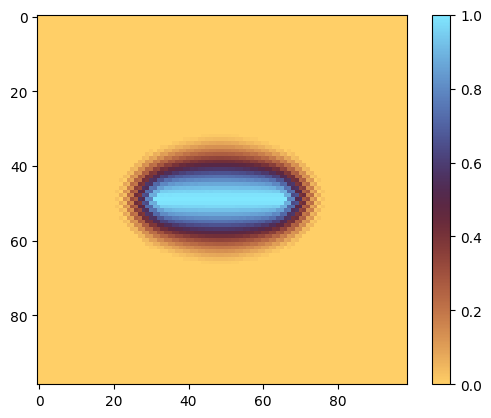

In [44]:
plt.imshow(alpha_new.reshape((N, N)), cmap="managua")
plt.colorbar()
plt.show()

In [ ]:
class FractureProblem:

    def __init__(self, epsilon, N):
        self.epsilon = epsilon
        self.N = N
        self.compute =eqx.Partial(fracture_strong_form, epsilon=epsilon)
        #self.jac = partial(dFdalpha, epsilon=epsilon)

    def function(self, snes, X, F):
        x = jnp.array(X.getArray())
        f = self.compute(x)
        F[:] = f 


# for the case when we need to pass jacobian as well to petsc solver
dFdalpha = jax.jacfwd(fracture_strong_form)

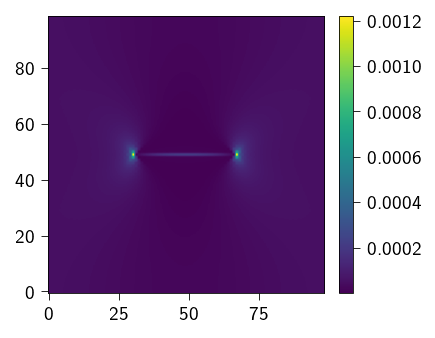

In [20]:
imshow(return_val=False)(lambda x :x)(strain_energy_plus)

In [21]:
jax.__version__

'0.4.30'

In [22]:
# register the function in charge of
# computing the nonlinear residual

frac = FractureProblem(eps, N)

snes = PETSc.SNES().create(comm=PETSc.COMM_SELF)
f = PETSc.Vec().createSeq(N * N)
snes.setFunction(frac.function, f)

alpha_lb = f.duplicate()
alpha_ub = f.duplicate()
alpha_lb.setArray(structure.reshape(-1))
alpha_ub.set(1)

snes.setUseMF(True)
snes.getKSP().setType('cg')

snes.setType("vinewtonrsls")
snes.setVariableBounds(alpha_lb, alpha_ub)
snes.setTolerances(atol=1e-8, rtol=1e-10)
snes.setConvergenceHistory()
snes.setConvergedReason(reason=PETSc.SNES.ConvergedReason.CONVERGED_FNORM_ABS)
snes.getKSP().setConvergedReason(reason=PETSc.KSP.ConvergedReason.CONVERGED_ATOL)
snes.setMonitor(lambda _, it, residual: print(it, residual))


b, alpha = None, f.duplicate()
alpha.setArray(structure.reshape(-1))  # zero inital guess

snes.solve(b, alpha)
print(PETSc.SNES.ConvergedReason.CONVERGED_FNORM_ABS == snes.getConvergedReason())
print(snes.getKSP().getConvergedReason())


snes.view()
_ = snes.destroy()

0 9.438962786807954
1 2.6469312602578805
2 0.8851912804187733
3 0.04188464560249006
4 0.005969123284172579
5 4.8852971304445077e-08
6 2.1318936773795206e-13
True
2
SNES Object: 1 MPI process
  type: vinewtonrsls
  maximum iterations=50, maximum function evaluations=10000
  tolerances: relative=1e-10, absolute=1e-08, solution=1e-08
  total number of linear solver iterations=129
  total number of function evaluations=142
  norm schedule ALWAYS
  SNESLineSearch Object: 1 MPI process
    type: bt
      interpolation: cubic
      alpha=0.000000e+00
    maxstep=1.000000e+08, minlambda=1.000000e-12
    tolerances: relative=1.000000e-08, absolute=1.000000e-15, lambda=1.000000e-08
    maximum iterations=40
  KSP Object: 1 MPI process
    type: cg
    maximum iterations=10000, initial guess is zero
    tolerances:  relative=1e-05, absolute=1e-50, divergence=10000.
    left preconditioning
    using PRECONDITIONED norm type for convergence test
  PC Object: 1 MPI process
    type: none
    linear

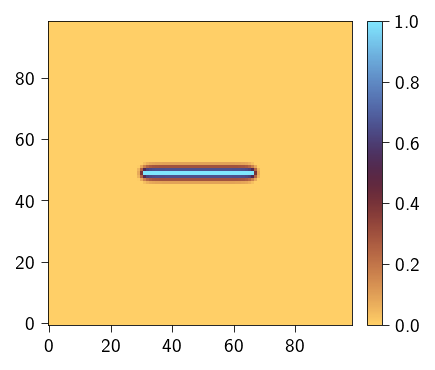

In [23]:
imshow(cmap=cmc.managua, return_val=False)(lambda x: x)(alpha.array.reshape((N, N)))

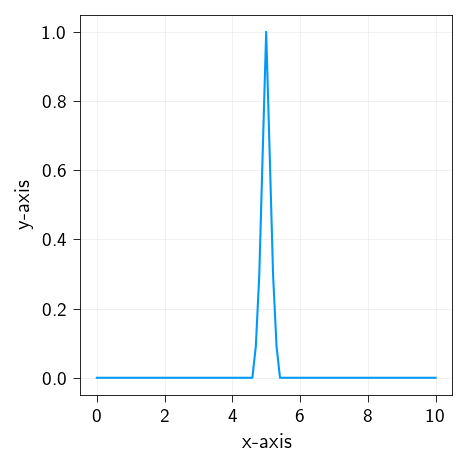

In [24]:
plot()(lambda x: x)(
    (np.linspace(0, length, num=N), alpha.array.reshape((N, N))[:, int(N / 2)])
)

In [35]:
alpha_prev = structure
applied_strains = np.diff(np.linspace(0, 2e-1, num=200))
eps = jnp.zeros([ndim, ndim, N, N])
deps = jnp.zeros([ndim, ndim, N, N])

for inc, deps_avg in enumerate(applied_strains):
    
    deps = deps.at[0, 0].set(deps_avg)

    # initial residual: distribute "DE" over grid using "K4"
    b = -G_K_deps(deps, alpha_prev)
    eps = jax.lax.add(eps, deps)
    _G_K_deps = jax.jit(partial(G_K_deps, alpha=alpha_prev))
    state = (deps, b, eps)

    final_state = newton_krylov_solver(
        state, tol=1e-8, A=_G_K_deps, max_iter=30, krylov_solver=conjugate_gradient
    )

    eps = final_state[2]

    frac = FractureProblem(eps, N)

    snes = PETSc.SNES().create(comm=PETSc.COMM_SELF)
    f = PETSc.Vec().createSeq(N * N)
    snes.setFunction(frac.function, f)

    alpha_lb = f.duplicate()
    alpha_ub = f.duplicate()
    alpha_lb.setArray(alpha_prev.reshape(-1))
    alpha_ub.set(1)

    snes.setUseMF(True)
    snes.getKSP().setType("cg")

    snes.setType("vinewtonrsls")
    snes.setVariableBounds(alpha_lb, alpha_ub)
    snes.setTolerances(atol=1e-8, rtol=1e-10)
    snes.setConvergenceHistory()
    snes.setConvergedReason(reason=PETSc.SNES.ConvergedReason.CONVERGED_FNORM_ABS)
    snes.getKSP().setConvergedReason(reason=PETSc.KSP.ConvergedReason.CONVERGED_ATOL)

    b, alpha = None, f.duplicate()
    alpha.setArray(structure.reshape(-1))  # zero inital guess

    snes.solve(b, alpha)
    print(PETSc.SNES.ConvergedReason.CONVERGED_FNORM_ABS == snes.getConvergedReason())
    print(snes.getKSP().getConvergedReason())

    alpha_prev = alpha.getArray().reshape((N, N))

    _ = snes.destroy()

Converged, Residual value : 7.93203230207842e-09
True
2
Converged, Residual value : 8.278249052263994e-09
True
2
Converged, Residual value : 7.584749293043743e-09
True
2
Converged, Residual value : 6.892623410986616e-09
True
2
Converged, Residual value : 9.697588186967834e-09
True
2
Converged, Residual value : 9.705894906820199e-09
True
2
Converged, Residual value : 9.536827352368334e-09
True
2
Converged, Residual value : 9.721977941727304e-09
True
2
Converged, Residual value : 9.5688158401759e-09
True
2
Converged, Residual value : 9.261714453957313e-09
True
2
Converged, Residual value : 9.664320310276714e-09
True
2
Converged, Residual value : 8.717934379950834e-09
True
2
Converged, Residual value : 8.515044484572433e-09
True
2
Converged, Residual value : 8.673053576376339e-09
True
2
Converged, Residual value : 9.564906715642803e-09
True
2
Converged, Residual value : 9.551721229359999e-09
True
2
Converged, Residual value : 8.871350550515968e-09
True
2
Converged, Residual value : 8.7982

: 

: 

: 

In [1]:
imshow(cmap=cmc.roma, return_val=False)(lambda x: x)(alpha_prev)

NameError: name 'imshow' is not defined

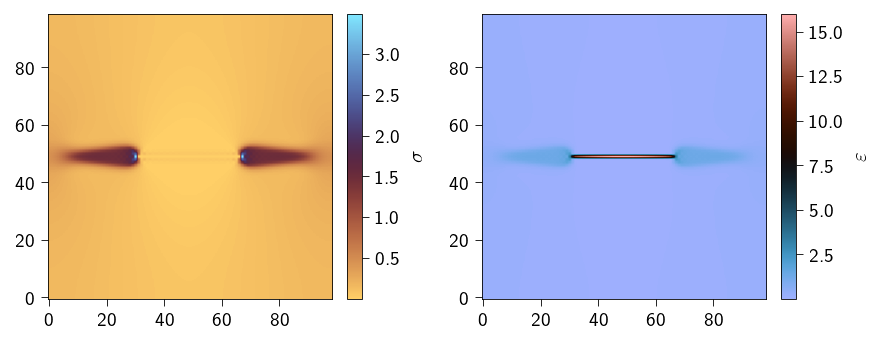

In [34]:
sig00, eps00 = get_stress_strains(final_state, alpha_prev)